In [1]:
import os
import pandas
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.transforms.functional as F
from torchvision.utils import make_grid

plt.rcParams["savefig.bbox"] = 'tight'

In [2]:
class CNN_Cinic10(nn.Module):
    def __init__(self):
        super(CNN_Cinic10, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(),
            nn.Conv2d(1024, 2048, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(2048),
            nn.LeakyReLU(),
            nn.Flatten()
        )

        self.z_mean = nn.Linear(2048, 256)
        self.z_log_var = nn.Linear(2048, 256)

        self.decoder = nn.Sequential(
            nn.Linear(256, 2048),
            nn.Unflatten(1, (2048, 1, 1)),
            nn.ConvTranspose2d(2048, 1024, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),            
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)
        dec = self.decoder(lat)
        
        return dec, mu, lv

    def reparam(self, mu, lv):
        std = torch.exp(0.5 * lv)
        eps = torch.randn_like(std)
        return mu + std * eps

    def get_latent(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)

        return lat

In [3]:
mean = [0.47889522, 0.47227842, 0.43047404]
std = [0.24205776, 0.23828046, 0.25874835]

transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

root_dir = '/media/mountHDD2/data/cinic10'

trainset = ImageFolder(root=root_dir + "/train", transform=transform)
train_dl = DataLoader(trainset, batch_size=256, shuffle=True, num_workers=24)
validset = ImageFolder(root=root_dir + "/valid", transform=transform)
valid_dl = DataLoader(validset, batch_size=256, shuffle=False, num_workers=24)
testset = ImageFolder(root=root_dir + "/test", transform=transform)
test_dl = DataLoader(testset, batch_size=128, shuffle=False, num_workers=24)

print(len(trainset), len(validset), len(testset))
print(len(train_dl), len(valid_dl), len(test_dl))

90000 90000 90000
352 352 704


In [4]:
sample, _ = trainset[0]
print(sample.shape)

torch.Size([3, 32, 32])


In [5]:
def gaussian_kls(mu, logvar):
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return torch.mean(kld_loss)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 1)

model = CNN_Cinic10().to(device)

optimizer = Adam(params = model.parameters(), lr = 0.005)

epochs = 200

scheduler = CosineAnnealingLR(optimizer, epochs*len(train_dl))

recon_loss = nn.MSELoss(reduction='none')

def loss_fn(recon_x, x):
    return torch.mean(torch.sum(recon_loss(recon_x, x), dim=(1,2,3)))

In [7]:
for epoch in range(epochs):
    model.train()
    tr_total_loss = {
        "rec_loss" : 0,
        "kl_loss" : 0
    }
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img, train_mu, train_lv = model(train_img)
        train_rec_loss = loss_fn(gen_img, train_img)
        train_kl_loss = gaussian_kls(train_mu, train_lv)
        train_loss = train_rec_loss + train_kl_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss["rec_loss"] += train_rec_loss.item()
        tr_total_loss["kl_loss"] += train_kl_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = {
            "rec_loss" : 0,
            "kl_loss" : 0
        }
        for valid_img, _ in tqdm(valid_dl):
            valid_img = valid_img.to(device)

            gen_img, valid_mu, valid_lv = model(valid_img)
            valid_rec_loss = loss_fn(gen_img, valid_img)
            valid_kl_loss = gaussian_kls(valid_mu, valid_lv)
            valid_loss = valid_rec_loss + valid_kl_loss

            va_total_loss["rec_loss"] += valid_rec_loss.item()
            va_total_loss["kl_loss"] += valid_kl_loss.item()

    print(f"Epoch: {epoch} - TrainRecLoss: {tr_total_loss['rec_loss']/len(train_dl)} - ValidRecLoss: {va_total_loss['rec_loss']/len(valid_dl)}")
    print(f"Epoch: {epoch} - TrainDivLoss: {tr_total_loss['kl_loss']/len(train_dl)} - ValidDivLoss: {va_total_loss['kl_loss']/len(valid_dl)}")

100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 71.58it/s]


Epoch: 0 - TrainRecLoss: 2275.585449912331 - ValidRecLoss: 1932.5651567632501
Epoch: 0 - TrainDivLoss: 6067.36684552106 - ValidDivLoss: 17821.413464741272


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 71.92it/s]


Epoch: 1 - TrainRecLoss: 1774.8474460948598 - ValidRecLoss: 1634.7107913277366
Epoch: 1 - TrainDivLoss: 166.0687219879844 - ValidDivLoss: 117.82992870157415


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.88it/s]


Epoch: 2 - TrainRecLoss: 1515.2398067821157 - ValidRecLoss: 1510.9870966131036
Epoch: 2 - TrainDivLoss: 110.72137971357866 - ValidDivLoss: 85.16665736111727


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 71.67it/s]


Epoch: 3 - TrainRecLoss: 1430.0969924926758 - ValidRecLoss: 1437.130391034213
Epoch: 3 - TrainDivLoss: 82.57488519495183 - ValidDivLoss: 86.16381125016646


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 71.83it/s]


Epoch: 4 - TrainRecLoss: 1373.168049552224 - ValidRecLoss: 1383.0259411551735
Epoch: 4 - TrainDivLoss: 80.77495297518644 - ValidDivLoss: 76.30661077932878


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 71.23it/s]


Epoch: 5 - TrainRecLoss: 1316.366527557373 - ValidRecLoss: 1303.1025581359863
Epoch: 5 - TrainDivLoss: 91.89372628385371 - ValidDivLoss: 135.55523419380188


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 71.52it/s]


Epoch: 6 - TrainRecLoss: 1264.705517508767 - ValidRecLoss: 1276.76246955178
Epoch: 6 - TrainDivLoss: 100.18089413642883 - ValidDivLoss: 101.96465056592768


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 71.43it/s]


Epoch: 7 - TrainRecLoss: 1231.51123567061 - ValidRecLoss: 1280.6504905007102
Epoch: 7 - TrainDivLoss: 79.26043821464886 - ValidDivLoss: 103.93146621097218


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 71.59it/s]


Epoch: 8 - TrainRecLoss: 1209.5317518060858 - ValidRecLoss: 1214.8734014684503
Epoch: 8 - TrainDivLoss: 85.51409212025729 - ValidDivLoss: 78.48646546493877


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.83it/s]


Epoch: 9 - TrainRecLoss: 1188.7094608653676 - ValidRecLoss: 1207.96382782676
Epoch: 9 - TrainDivLoss: 80.37760374762796 - ValidDivLoss: 75.84825346686624


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 70.11it/s]


Epoch: 10 - TrainRecLoss: 1159.661643635143 - ValidRecLoss: 1177.1000683524392
Epoch: 10 - TrainDivLoss: 86.22709902850065 - ValidDivLoss: 70.3278435902162


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.85it/s]


Epoch: 11 - TrainRecLoss: 1139.4960143349388 - ValidRecLoss: 1153.6115899519486
Epoch: 11 - TrainDivLoss: 74.7634318633513 - ValidDivLoss: 69.71801044724204


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 71.04it/s]


Epoch: 12 - TrainRecLoss: 1121.5146614421499 - ValidRecLoss: 1128.2708624059503
Epoch: 12 - TrainDivLoss: 73.61888480186462 - ValidDivLoss: 75.23537914319472


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.58it/s]


Epoch: 13 - TrainRecLoss: 1106.0822998393667 - ValidRecLoss: 1110.9691538377242
Epoch: 13 - TrainDivLoss: 73.26188875328411 - ValidDivLoss: 83.68587570840663


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 71.30it/s]


Epoch: 14 - TrainRecLoss: 1081.8952120000665 - ValidRecLoss: 1128.4738812880082
Epoch: 14 - TrainDivLoss: 73.91743226484819 - ValidDivLoss: 73.10166304761714


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.09it/s]


Epoch: 15 - TrainRecLoss: 1065.6252509030428 - ValidRecLoss: 1090.4991335435348
Epoch: 15 - TrainDivLoss: 76.23805671388453 - ValidDivLoss: 75.71449020775881


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 68.83it/s]


Epoch: 16 - TrainRecLoss: 1053.3711624145508 - ValidRecLoss: 1081.7492899461226
Epoch: 16 - TrainDivLoss: 75.90406585823406 - ValidDivLoss: 73.43531172925776


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.67it/s]


Epoch: 17 - TrainRecLoss: 1041.726161956787 - ValidRecLoss: 1044.2669098593972
Epoch: 17 - TrainDivLoss: 77.97830447283658 - ValidDivLoss: 85.91187400167638


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.94it/s]


Epoch: 18 - TrainRecLoss: 1029.5745938040993 - ValidRecLoss: 1086.0337552157316
Epoch: 18 - TrainDivLoss: 74.62302878769961 - ValidDivLoss: 72.47007143497467


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 71.49it/s]


Epoch: 19 - TrainRecLoss: 1018.9020243558017 - ValidRecLoss: 1030.447338624434
Epoch: 19 - TrainDivLoss: 66.69948109713468 - ValidDivLoss: 63.61692823063243


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.57it/s]


Epoch: 20 - TrainRecLoss: 1006.1431888233532 - ValidRecLoss: 1014.6565343683416
Epoch: 20 - TrainDivLoss: 64.01963140747763 - ValidDivLoss: 63.79588111964139


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 68.85it/s]


Epoch: 21 - TrainRecLoss: 994.8763623671098 - ValidRecLoss: 1060.7392865961249
Epoch: 21 - TrainDivLoss: 67.02717371420427 - ValidDivLoss: 65.7985267314044


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.72it/s]


Epoch: 22 - TrainRecLoss: 984.7774349559437 - ValidRecLoss: 1017.7699865861373
Epoch: 22 - TrainDivLoss: 69.56869126449932 - ValidDivLoss: 70.18953887982802


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 71.30it/s]


Epoch: 23 - TrainRecLoss: 970.4601795890114 - ValidRecLoss: 987.7381257143887
Epoch: 23 - TrainDivLoss: 68.02201333912936 - ValidDivLoss: 69.72223935344003


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.95it/s]


Epoch: 24 - TrainRecLoss: 960.6593185771595 - ValidRecLoss: 991.7965224872936
Epoch: 24 - TrainDivLoss: 67.45546532760967 - ValidDivLoss: 70.39103787595576


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.58it/s]


Epoch: 25 - TrainRecLoss: 950.150504025546 - ValidRecLoss: 962.67337920449
Epoch: 25 - TrainDivLoss: 65.09094502709128 - ValidDivLoss: 65.50287854671478


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.24it/s]


Epoch: 26 - TrainRecLoss: 941.0771309245716 - ValidRecLoss: 946.9109304601496
Epoch: 26 - TrainDivLoss: 65.49694240093231 - ValidDivLoss: 63.808032209222965


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 68.95it/s]


Epoch: 27 - TrainRecLoss: 932.2545450383967 - ValidRecLoss: 962.967869498513
Epoch: 27 - TrainDivLoss: 65.6350795247338 - ValidDivLoss: 66.4928287484429


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.76it/s]


Epoch: 28 - TrainRecLoss: 922.7077855196866 - ValidRecLoss: 949.9280300140381
Epoch: 28 - TrainDivLoss: 66.0158120285381 - ValidDivLoss: 67.64485564015128


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.81it/s]


Epoch: 29 - TrainRecLoss: 913.1472780054265 - ValidRecLoss: 920.134196801619
Epoch: 29 - TrainDivLoss: 67.54353524338116 - ValidDivLoss: 65.62441938573664


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.60it/s]


Epoch: 30 - TrainRecLoss: 903.5516083457253 - ValidRecLoss: 910.1249568245628
Epoch: 30 - TrainDivLoss: 66.91532472046939 - ValidDivLoss: 67.19621940092607


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.10it/s]


Epoch: 31 - TrainRecLoss: 893.4584227475253 - ValidRecLoss: 907.6543529683894
Epoch: 31 - TrainDivLoss: 68.96765107458288 - ValidDivLoss: 70.56138401681727


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 68.93it/s]


Epoch: 32 - TrainRecLoss: 888.3564938631924 - ValidRecLoss: 908.3862465945157
Epoch: 32 - TrainDivLoss: 67.62721707604148 - ValidDivLoss: 67.51792321421884


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 70.05it/s]


Epoch: 33 - TrainRecLoss: 881.098408612338 - ValidRecLoss: 890.1443436362526
Epoch: 33 - TrainDivLoss: 67.3743977655064 - ValidDivLoss: 67.45925853469156


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 71.11it/s]


Epoch: 34 - TrainRecLoss: 875.5873336791992 - ValidRecLoss: 885.2171067324551
Epoch: 34 - TrainDivLoss: 67.48594592918049 - ValidDivLoss: 68.3062476461584


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 70.37it/s]


Epoch: 35 - TrainRecLoss: 869.4450159939853 - ValidRecLoss: 878.3046184886585
Epoch: 35 - TrainDivLoss: 67.34975336898457 - ValidDivLoss: 66.68128710443324


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 71.03it/s]


Epoch: 36 - TrainRecLoss: 865.5345164212314 - ValidRecLoss: 867.9994091554122
Epoch: 36 - TrainDivLoss: 67.41546508398923 - ValidDivLoss: 67.15153155543588


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.26it/s]


Epoch: 37 - TrainRecLoss: 861.9330451271751 - ValidRecLoss: 859.40358543396
Epoch: 37 - TrainDivLoss: 67.66921683874997 - ValidDivLoss: 69.08532707257704


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.16it/s]


Epoch: 38 - TrainRecLoss: 857.1495753201572 - ValidRecLoss: 862.7386257865212
Epoch: 38 - TrainDivLoss: 68.0807232206518 - ValidDivLoss: 69.49418924071573


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.72it/s]


Epoch: 39 - TrainRecLoss: 853.0274110273881 - ValidRecLoss: 857.3096578771418
Epoch: 39 - TrainDivLoss: 68.32530723918568 - ValidDivLoss: 68.03795543583956


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.86it/s]


Epoch: 40 - TrainRecLoss: 850.0100409767845 - ValidRecLoss: 857.5175939906727
Epoch: 40 - TrainDivLoss: 69.07655167579651 - ValidDivLoss: 69.25939613038844


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.78it/s]


Epoch: 41 - TrainRecLoss: 843.8483616222035 - ValidRecLoss: 850.5136150013317
Epoch: 41 - TrainDivLoss: 70.20623415166682 - ValidDivLoss: 70.03919413956729


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.46it/s]


Epoch: 42 - TrainRecLoss: 839.645766171542 - ValidRecLoss: 852.3743123141202
Epoch: 42 - TrainDivLoss: 70.95229057832198 - ValidDivLoss: 72.39878618717194


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 68.67it/s]


Epoch: 43 - TrainRecLoss: 835.927808414806 - ValidRecLoss: 841.0916548642246
Epoch: 43 - TrainDivLoss: 71.66631683436307 - ValidDivLoss: 71.8015305887569


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.89it/s]


Epoch: 44 - TrainRecLoss: 832.3137661327015 - ValidRecLoss: 839.7113633589311
Epoch: 44 - TrainDivLoss: 71.83638635548678 - ValidDivLoss: 72.29767843809995


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.68it/s]


Epoch: 45 - TrainRecLoss: 827.2099054509944 - ValidRecLoss: 833.7050526358864
Epoch: 45 - TrainDivLoss: 72.62845847823404 - ValidDivLoss: 72.20743786204945


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 71.40it/s]


Epoch: 46 - TrainRecLoss: 825.5439754832875 - ValidRecLoss: 834.1987426931208
Epoch: 46 - TrainDivLoss: 72.92827783931385 - ValidDivLoss: 73.55762790549885


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.85it/s]


Epoch: 47 - TrainRecLoss: 823.1839838894931 - ValidRecLoss: 828.99145377766
Epoch: 47 - TrainDivLoss: 73.28447664867748 - ValidDivLoss: 73.8708964586258


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.91it/s]


Epoch: 48 - TrainRecLoss: 820.7763642397794 - ValidRecLoss: 838.0451423471624
Epoch: 48 - TrainDivLoss: 73.34434366226196 - ValidDivLoss: 71.8964642719789


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.56it/s]


Epoch: 49 - TrainRecLoss: 817.3534029180354 - ValidRecLoss: 834.2808433879505
Epoch: 49 - TrainDivLoss: 73.58805970712142 - ValidDivLoss: 73.2973115010695


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.35it/s]


Epoch: 50 - TrainRecLoss: 814.0670474659313 - ValidRecLoss: 825.9798428795555
Epoch: 50 - TrainDivLoss: 74.02717800573869 - ValidDivLoss: 74.59923214262182


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.74it/s]


Epoch: 51 - TrainRecLoss: 811.6184595281428 - ValidRecLoss: 818.1123697107488
Epoch: 51 - TrainDivLoss: 74.37698620015925 - ValidDivLoss: 74.54538714885712


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.72it/s]


Epoch: 52 - TrainRecLoss: 808.3470266515559 - ValidRecLoss: 818.8191458095204
Epoch: 52 - TrainDivLoss: 74.50444540110502 - ValidDivLoss: 74.43153341249986


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.79it/s]


Epoch: 53 - TrainRecLoss: 806.5179467634721 - ValidRecLoss: 819.7455559643832
Epoch: 53 - TrainDivLoss: 74.99164188991894 - ValidDivLoss: 76.35973054712468


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 68.90it/s]


Epoch: 54 - TrainRecLoss: 803.2731699510055 - ValidRecLoss: 817.7489592812278
Epoch: 54 - TrainDivLoss: 75.46392683549361 - ValidDivLoss: 75.20677152546969


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.07it/s]


Epoch: 55 - TrainRecLoss: 800.8280783566562 - ValidRecLoss: 810.3380774584683
Epoch: 55 - TrainDivLoss: 75.68516221913424 - ValidDivLoss: 76.58448123931885


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.89it/s]


Epoch: 56 - TrainRecLoss: 798.5312156677246 - ValidRecLoss: 814.5745157762008
Epoch: 56 - TrainDivLoss: 75.84323471242732 - ValidDivLoss: 74.37425003268503


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.72it/s]


Epoch: 57 - TrainRecLoss: 796.7226430719548 - ValidRecLoss: 808.9200103933161
Epoch: 57 - TrainDivLoss: 76.03563967618075 - ValidDivLoss: 76.43741076642817


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 70.03it/s]


Epoch: 58 - TrainRecLoss: 795.0001628182151 - ValidRecLoss: 809.7477586919612
Epoch: 58 - TrainDivLoss: 76.2100228396329 - ValidDivLoss: 75.70134087042375


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.22it/s]


Epoch: 59 - TrainRecLoss: 793.2174953113903 - ValidRecLoss: 816.9257387681441
Epoch: 59 - TrainDivLoss: 76.28657360510392 - ValidDivLoss: 77.17776224829935


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.59it/s]


Epoch: 60 - TrainRecLoss: 790.9320257360285 - ValidRecLoss: 812.4702753587203
Epoch: 60 - TrainDivLoss: 76.47536897659302 - ValidDivLoss: 76.86635846441442


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.87it/s]


Epoch: 61 - TrainRecLoss: 788.2703602530739 - ValidRecLoss: 807.4105010466142
Epoch: 61 - TrainDivLoss: 76.9343454621055 - ValidDivLoss: 76.23354739492589


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 70.33it/s]


Epoch: 62 - TrainRecLoss: 785.8717724193226 - ValidRecLoss: 813.5083078037609
Epoch: 62 - TrainDivLoss: 77.23547534509139 - ValidDivLoss: 76.48753838105635


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 70.34it/s]


Epoch: 63 - TrainRecLoss: 783.9901374470104 - ValidRecLoss: 804.3616456985474
Epoch: 63 - TrainDivLoss: 77.45657972856002 - ValidDivLoss: 78.17662573944439


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 70.38it/s]


Epoch: 64 - TrainRecLoss: 781.8334047144109 - ValidRecLoss: 801.5019842494618
Epoch: 64 - TrainDivLoss: 77.8877462907271 - ValidDivLoss: 77.5579505075108


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 68.84it/s]


Epoch: 65 - TrainRecLoss: 779.7875683524392 - ValidRecLoss: 802.7925650856712
Epoch: 65 - TrainDivLoss: 78.13827826760031 - ValidDivLoss: 78.82372422651811


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 68.60it/s]


Epoch: 66 - TrainRecLoss: 778.712085723877 - ValidRecLoss: 803.5607919692993
Epoch: 66 - TrainDivLoss: 78.32345685091886 - ValidDivLoss: 78.90605382485823


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.95it/s]


Epoch: 67 - TrainRecLoss: 776.5940489335494 - ValidRecLoss: 803.6338976079768
Epoch: 67 - TrainDivLoss: 78.38260423053394 - ValidDivLoss: 78.56085591966456


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 71.22it/s]


Epoch: 68 - TrainRecLoss: 775.0375596826726 - ValidRecLoss: 803.3367130973122
Epoch: 68 - TrainDivLoss: 78.47472769563848 - ValidDivLoss: 78.62974151698026


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 71.04it/s]


Epoch: 69 - TrainRecLoss: 773.6749220761386 - ValidRecLoss: 801.5707954059948
Epoch: 69 - TrainDivLoss: 78.58800686489452 - ValidDivLoss: 77.76568323915654


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.54it/s]


Epoch: 70 - TrainRecLoss: 772.1785325137051 - ValidRecLoss: 811.2016358809037
Epoch: 70 - TrainDivLoss: 78.75196599960327 - ValidDivLoss: 79.94954083182596


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 67.12it/s]


Epoch: 71 - TrainRecLoss: 771.1044521331787 - ValidRecLoss: 800.2713162682273
Epoch: 71 - TrainDivLoss: 78.85769575292414 - ValidDivLoss: 78.53703819621693


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 68.40it/s]


Epoch: 72 - TrainRecLoss: 770.4329157742587 - ValidRecLoss: 800.7790340076793
Epoch: 72 - TrainDivLoss: 79.00979471206665 - ValidDivLoss: 78.22461046955802


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.48it/s]


Epoch: 73 - TrainRecLoss: 767.4524530930953 - ValidRecLoss: 799.954511642456
Epoch: 73 - TrainDivLoss: 79.13345297900113 - ValidDivLoss: 78.65015418962999


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 71.18it/s]


Epoch: 74 - TrainRecLoss: 766.7551208842884 - ValidRecLoss: 798.8793432062322
Epoch: 74 - TrainDivLoss: 79.37478908625516 - ValidDivLoss: 79.44927779110995


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 70.38it/s]


Epoch: 75 - TrainRecLoss: 764.5814496820623 - ValidRecLoss: 802.5061544938521
Epoch: 75 - TrainDivLoss: 79.68545985221863 - ValidDivLoss: 79.90059531818737


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.71it/s]


Epoch: 76 - TrainRecLoss: 764.0661813562566 - ValidRecLoss: 804.6459345384078
Epoch: 76 - TrainDivLoss: 79.86065940423445 - ValidDivLoss: 79.55632807991721


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 68.82it/s]


Epoch: 77 - TrainRecLoss: 761.469667781483 - ValidRecLoss: 797.0026189630681
Epoch: 77 - TrainDivLoss: 80.00355117971247 - ValidDivLoss: 79.45949812368913


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.32it/s]


Epoch: 78 - TrainRecLoss: 760.3539480729537 - ValidRecLoss: 797.3600274866277
Epoch: 78 - TrainDivLoss: 80.12529867345637 - ValidDivLoss: 80.75746870040894


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.59it/s]


Epoch: 79 - TrainRecLoss: 758.3102427395908 - ValidRecLoss: 796.3569184216586
Epoch: 79 - TrainDivLoss: 80.33224407109347 - ValidDivLoss: 79.91849665208296


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.91it/s]


Epoch: 80 - TrainRecLoss: 757.6338405609131 - ValidRecLoss: 793.626394705339
Epoch: 80 - TrainDivLoss: 80.60597881403837 - ValidDivLoss: 80.22416667504744


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.60it/s]


Epoch: 81 - TrainRecLoss: 755.0476764332165 - ValidRecLoss: 796.0089483261108
Epoch: 81 - TrainDivLoss: 80.84730770371176 - ValidDivLoss: 80.60671576586637


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.18it/s]


Epoch: 82 - TrainRecLoss: 753.9294253262607 - ValidRecLoss: 795.4645533995194
Epoch: 82 - TrainDivLoss: 81.01390108195218 - ValidDivLoss: 80.64314889907837


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 67.86it/s]


Epoch: 83 - TrainRecLoss: 752.8536444577304 - ValidRecLoss: 797.232233914462
Epoch: 83 - TrainDivLoss: 81.13989459384571 - ValidDivLoss: 81.2460906939073


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 70.34it/s]


Epoch: 84 - TrainRecLoss: 751.7254189577969 - ValidRecLoss: 794.3080827539617
Epoch: 84 - TrainDivLoss: 81.3177278475328 - ValidDivLoss: 82.03851487419821


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 71.19it/s]


Epoch: 85 - TrainRecLoss: 750.1237768693404 - ValidRecLoss: 791.8611257726496
Epoch: 85 - TrainDivLoss: 81.44198235598478 - ValidDivLoss: 81.04806843670931


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.64it/s]


Epoch: 86 - TrainRecLoss: 748.860159440474 - ValidRecLoss: 792.9891186627475
Epoch: 86 - TrainDivLoss: 81.50411800904708 - ValidDivLoss: 80.3169722773812


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 68.76it/s]


Epoch: 87 - TrainRecLoss: 747.4827943281693 - ValidRecLoss: 792.2156046087092
Epoch: 87 - TrainDivLoss: 81.64548351547934 - ValidDivLoss: 81.95622931827198


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.90it/s]


Epoch: 88 - TrainRecLoss: 745.5322331515225 - ValidRecLoss: 791.6707363128662
Epoch: 88 - TrainDivLoss: 81.7823556986722 - ValidDivLoss: 80.81099299951033


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 68.36it/s]


Epoch: 89 - TrainRecLoss: 744.8905324068936 - ValidRecLoss: 790.7234965237705
Epoch: 89 - TrainDivLoss: 81.88117280873385 - ValidDivLoss: 81.29725803028454


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.60it/s]


Epoch: 90 - TrainRecLoss: 743.2316441969438 - ValidRecLoss: 792.9229897585782
Epoch: 90 - TrainDivLoss: 81.9942512295463 - ValidDivLoss: 82.55371880531311


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 70.01it/s]


Epoch: 91 - TrainRecLoss: 742.7882404327393 - ValidRecLoss: 793.0875872698697
Epoch: 91 - TrainDivLoss: 82.11242053725503 - ValidDivLoss: 81.64037483388728


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 70.19it/s]


Epoch: 92 - TrainRecLoss: 741.5773398659446 - ValidRecLoss: 791.3174670826305
Epoch: 92 - TrainDivLoss: 82.15723724798723 - ValidDivLoss: 81.26090147278525


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.35it/s]


Epoch: 93 - TrainRecLoss: 739.9410218325528 - ValidRecLoss: 794.1326430927624
Epoch: 93 - TrainDivLoss: 82.2538071979176 - ValidDivLoss: 83.08625093373385


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.23it/s]


Epoch: 94 - TrainRecLoss: 739.2333576895974 - ValidRecLoss: 792.9758990027688
Epoch: 94 - TrainDivLoss: 82.35757158019327 - ValidDivLoss: 80.72262016209689


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.52it/s]


Epoch: 95 - TrainRecLoss: 737.6905694441361 - ValidRecLoss: 794.8963283192028
Epoch: 95 - TrainDivLoss: 82.46210345354947 - ValidDivLoss: 82.68445056135005


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.58it/s]


Epoch: 96 - TrainRecLoss: 736.9573627818714 - ValidRecLoss: 790.8187652067704
Epoch: 96 - TrainDivLoss: 82.51087190888144 - ValidDivLoss: 82.63336196812716


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.73it/s]


Epoch: 97 - TrainRecLoss: 735.8190071799538 - ValidRecLoss: 790.8031819950451
Epoch: 97 - TrainDivLoss: 82.70007779381491 - ValidDivLoss: 82.30745120482011


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 68.96it/s]


Epoch: 98 - TrainRecLoss: 734.3833101445979 - ValidRecLoss: 793.2653343027288
Epoch: 98 - TrainDivLoss: 82.77118782563643 - ValidDivLoss: 81.94308603893627


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 68.88it/s]


Epoch: 99 - TrainRecLoss: 733.3742041154342 - ValidRecLoss: 791.6652394208041
Epoch: 99 - TrainDivLoss: 82.79527984965931 - ValidDivLoss: 82.47370557351546


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.09it/s]


Epoch: 100 - TrainRecLoss: 732.4872576973655 - ValidRecLoss: 792.9701206900857
Epoch: 100 - TrainDivLoss: 82.8938587362116 - ValidDivLoss: 82.55208750204606


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 70.31it/s]


Epoch: 101 - TrainRecLoss: 731.5281271501021 - ValidRecLoss: 793.0086895335804
Epoch: 101 - TrainDivLoss: 82.98285566676746 - ValidDivLoss: 82.92016454176469


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.66it/s]


Epoch: 102 - TrainRecLoss: 730.512148770419 - ValidRecLoss: 788.9064333655617
Epoch: 102 - TrainDivLoss: 83.04780912399292 - ValidDivLoss: 83.0857848037373


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.71it/s]


Epoch: 103 - TrainRecLoss: 729.730957551436 - ValidRecLoss: 794.3379288586704
Epoch: 103 - TrainDivLoss: 83.13690486821261 - ValidDivLoss: 82.27301575920798


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 68.20it/s]


Epoch: 104 - TrainRecLoss: 728.3091368241744 - ValidRecLoss: 792.5391985286366
Epoch: 104 - TrainDivLoss: 83.2177236513658 - ValidDivLoss: 83.43950395150618


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 67.43it/s]


Epoch: 105 - TrainRecLoss: 728.131442676891 - ValidRecLoss: 790.140233039856
Epoch: 105 - TrainDivLoss: 83.3230495669625 - ValidDivLoss: 82.86939321864735


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 68.73it/s]


Epoch: 106 - TrainRecLoss: 726.7069996920499 - ValidRecLoss: 790.3873838944869
Epoch: 106 - TrainDivLoss: 83.38234357400374 - ValidDivLoss: 83.49083345586604


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.62it/s]


Epoch: 107 - TrainRecLoss: 725.6695534099232 - ValidRecLoss: 792.3636802326549
Epoch: 107 - TrainDivLoss: 83.44729308648543 - ValidDivLoss: 82.68450450897217


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.64it/s]


Epoch: 108 - TrainRecLoss: 725.1052537397904 - ValidRecLoss: 792.4009522524747
Epoch: 108 - TrainDivLoss: 83.57865381240845 - ValidDivLoss: 84.08287776600231


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 70.01it/s]


Epoch: 109 - TrainRecLoss: 724.0104500163685 - ValidRecLoss: 791.5724164789373
Epoch: 109 - TrainDivLoss: 83.65635581450029 - ValidDivLoss: 82.45342692461881


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 68.63it/s]


Epoch: 110 - TrainRecLoss: 723.4941189505837 - ValidRecLoss: 792.8955001831055
Epoch: 110 - TrainDivLoss: 83.74222393469377 - ValidDivLoss: 83.35517137700862


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.63it/s]


Epoch: 111 - TrainRecLoss: 722.2449736161666 - ValidRecLoss: 791.3439436825839
Epoch: 111 - TrainDivLoss: 83.88487339019775 - ValidDivLoss: 84.61914042993025


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.78it/s]


Epoch: 112 - TrainRecLoss: 721.0948427373713 - ValidRecLoss: 793.2136772329158
Epoch: 112 - TrainDivLoss: 83.9302179813385 - ValidDivLoss: 83.62940846789967


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 70.17it/s]


Epoch: 113 - TrainRecLoss: 720.2368108575994 - ValidRecLoss: 791.3317949988625
Epoch: 113 - TrainDivLoss: 84.10283142870122 - ValidDivLoss: 83.0000267679041


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 70.03it/s]


Epoch: 114 - TrainRecLoss: 719.2041423104026 - ValidRecLoss: 791.2732037630948
Epoch: 114 - TrainDivLoss: 84.11110999367453 - ValidDivLoss: 83.87698888778687


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 68.98it/s]


Epoch: 115 - TrainRecLoss: 718.3211780894886 - ValidRecLoss: 791.5868695865978
Epoch: 115 - TrainDivLoss: 84.2931259762157 - ValidDivLoss: 83.96850999918851


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 68.80it/s]


Epoch: 116 - TrainRecLoss: 717.5103730288419 - ValidRecLoss: 791.6969782222401
Epoch: 116 - TrainDivLoss: 84.3674584085291 - ValidDivLoss: 83.19251803918318


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.21it/s]


Epoch: 117 - TrainRecLoss: 717.0416337793523 - ValidRecLoss: 793.1088445836848
Epoch: 117 - TrainDivLoss: 84.3968191797083 - ValidDivLoss: 84.32733472910795


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.43it/s]


Epoch: 118 - TrainRecLoss: 716.1930170926181 - ValidRecLoss: 791.3892648003318
Epoch: 118 - TrainDivLoss: 84.5094262903387 - ValidDivLoss: 84.3515240279111


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.77it/s]


Epoch: 119 - TrainRecLoss: 714.81091707403 - ValidRecLoss: 793.3972043991089
Epoch: 119 - TrainDivLoss: 84.5965468233282 - ValidDivLoss: 85.14403685656461


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 70.39it/s]


Epoch: 120 - TrainRecLoss: 714.1383295926181 - ValidRecLoss: 791.4998474988071
Epoch: 120 - TrainDivLoss: 84.67518032680859 - ValidDivLoss: 83.64494612000205


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 68.56it/s]


Epoch: 121 - TrainRecLoss: 713.8973653966731 - ValidRecLoss: 793.3599392284046
Epoch: 121 - TrainDivLoss: 84.76171677762812 - ValidDivLoss: 84.50452332063155


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 68.57it/s]


Epoch: 122 - TrainRecLoss: 713.0517812208695 - ValidRecLoss: 790.4291203238747
Epoch: 122 - TrainDivLoss: 84.7981417612596 - ValidDivLoss: 84.49919720129533


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 70.25it/s]


Epoch: 123 - TrainRecLoss: 712.4380167180842 - ValidRecLoss: 790.6686684001576
Epoch: 123 - TrainDivLoss: 84.84621962634 - ValidDivLoss: 84.10174291784114


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.42it/s]


Epoch: 124 - TrainRecLoss: 711.7438359694047 - ValidRecLoss: 792.7814312848178
Epoch: 124 - TrainDivLoss: 84.93879571827975 - ValidDivLoss: 84.9171376878565


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 70.34it/s]


Epoch: 125 - TrainRecLoss: 711.1859623302113 - ValidRecLoss: 791.7025147351352
Epoch: 125 - TrainDivLoss: 84.99174358628012 - ValidDivLoss: 83.8423790064725


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 68.62it/s]


Epoch: 126 - TrainRecLoss: 710.1667034842751 - ValidRecLoss: 791.9508229168979
Epoch: 126 - TrainDivLoss: 85.02063077146357 - ValidDivLoss: 85.21433104168285


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.17it/s]


Epoch: 127 - TrainRecLoss: 709.5184241208163 - ValidRecLoss: 793.0964514125477
Epoch: 127 - TrainDivLoss: 85.1503323208202 - ValidDivLoss: 84.57672608982433


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 68.69it/s]


Epoch: 128 - TrainRecLoss: 708.8141729181463 - ValidRecLoss: 793.8992796811191
Epoch: 128 - TrainDivLoss: 85.19334838607095 - ValidDivLoss: 84.69778682968833


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 71.29it/s]


Epoch: 129 - TrainRecLoss: 708.4604611830277 - ValidRecLoss: 792.9635670401833
Epoch: 129 - TrainDivLoss: 85.2497557293285 - ValidDivLoss: 84.93130404298955


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.52it/s]


Epoch: 130 - TrainRecLoss: 707.6462565335361 - ValidRecLoss: 791.8722811612216
Epoch: 130 - TrainDivLoss: 85.3351650021293 - ValidDivLoss: 84.83445750583302


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.86it/s]


Epoch: 131 - TrainRecLoss: 707.0044791481712 - ValidRecLoss: 792.0331592559814
Epoch: 131 - TrainDivLoss: 85.35369597781788 - ValidDivLoss: 84.82626631043173


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 68.06it/s]


Epoch: 132 - TrainRecLoss: 706.3912161046809 - ValidRecLoss: 790.9846208745784
Epoch: 132 - TrainDivLoss: 85.43538156422701 - ValidDivLoss: 84.99276568672873


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.04it/s]


Epoch: 133 - TrainRecLoss: 705.5390123887496 - ValidRecLoss: 792.048412583091
Epoch: 133 - TrainDivLoss: 85.52379380572926 - ValidDivLoss: 84.96112598072399


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 70.35it/s]


Epoch: 134 - TrainRecLoss: 705.3360127535733 - ValidRecLoss: 793.5961401679299
Epoch: 134 - TrainDivLoss: 85.53231646797873 - ValidDivLoss: 85.20744794065303


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 70.05it/s]


Epoch: 135 - TrainRecLoss: 704.5217297293923 - ValidRecLoss: 793.409857749939
Epoch: 135 - TrainDivLoss: 85.63868130337109 - ValidDivLoss: 85.41617987372659


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.79it/s]


Epoch: 136 - TrainRecLoss: 704.0531723716042 - ValidRecLoss: 793.3987351330844
Epoch: 136 - TrainDivLoss: 85.66588434306058 - ValidDivLoss: 84.48741193251176


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.62it/s]


Epoch: 137 - TrainRecLoss: 703.142987164584 - ValidRecLoss: 794.0714645385742
Epoch: 137 - TrainDivLoss: 85.71800366314974 - ValidDivLoss: 84.83707408471541


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.15it/s]


Epoch: 138 - TrainRecLoss: 702.7419319152832 - ValidRecLoss: 793.1603132594715
Epoch: 138 - TrainDivLoss: 85.72290073741566 - ValidDivLoss: 85.11023523590781


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.79it/s]


Epoch: 139 - TrainRecLoss: 702.3114989887584 - ValidRecLoss: 794.2403779463334
Epoch: 139 - TrainDivLoss: 85.77755962718616 - ValidDivLoss: 85.55738668008284


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 70.05it/s]


Epoch: 140 - TrainRecLoss: 701.8710994720459 - ValidRecLoss: 793.5854632637718
Epoch: 140 - TrainDivLoss: 85.87378770654851 - ValidDivLoss: 85.44850368933244


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.71it/s]


Epoch: 141 - TrainRecLoss: 701.4708239815452 - ValidRecLoss: 792.7496280670166
Epoch: 141 - TrainDivLoss: 85.92591903426431 - ValidDivLoss: 85.86400695280595


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.81it/s]


Epoch: 142 - TrainRecLoss: 700.6192051280628 - ValidRecLoss: 794.3327356685292
Epoch: 142 - TrainDivLoss: 85.93946619467302 - ValidDivLoss: 85.59061839363791


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 68.57it/s]


Epoch: 143 - TrainRecLoss: 700.058836330067 - ValidRecLoss: 793.6729948737404
Epoch: 143 - TrainDivLoss: 85.97797185724431 - ValidDivLoss: 85.71161146597429


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.03it/s]


Epoch: 144 - TrainRecLoss: 699.6637781316584 - ValidRecLoss: 793.1622259833596
Epoch: 144 - TrainDivLoss: 86.05252627892928 - ValidDivLoss: 85.90465424277566


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.62it/s]


Epoch: 145 - TrainRecLoss: 699.3080016049472 - ValidRecLoss: 792.2066274989735
Epoch: 145 - TrainDivLoss: 86.10565081509677 - ValidDivLoss: 85.36633708260275


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.45it/s]


Epoch: 146 - TrainRecLoss: 698.6403012709184 - ValidRecLoss: 793.4246160333806
Epoch: 146 - TrainDivLoss: 86.10003607923335 - ValidDivLoss: 85.96608326651834


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.43it/s]


Epoch: 147 - TrainRecLoss: 698.5473312031139 - ValidRecLoss: 793.8807158903642
Epoch: 147 - TrainDivLoss: 86.16819722002202 - ValidDivLoss: 86.30731851404363


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.84it/s]


Epoch: 148 - TrainRecLoss: 697.7912920171565 - ValidRecLoss: 794.7979529120705
Epoch: 148 - TrainDivLoss: 86.22330000183798 - ValidDivLoss: 85.66144930232655


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 68.92it/s]


Epoch: 149 - TrainRecLoss: 697.5213394165039 - ValidRecLoss: 794.0346690958196
Epoch: 149 - TrainDivLoss: 86.24876596710898 - ValidDivLoss: 86.18859813430093


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.79it/s]


Epoch: 150 - TrainRecLoss: 697.0416316986084 - ValidRecLoss: 794.5057016719471
Epoch: 150 - TrainDivLoss: 86.30940805781971 - ValidDivLoss: 85.86049431020564


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.87it/s]


Epoch: 151 - TrainRecLoss: 696.4430247220126 - ValidRecLoss: 794.8726912411777
Epoch: 151 - TrainDivLoss: 86.34252192757346 - ValidDivLoss: 86.31886692480607


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 70.01it/s]


Epoch: 152 - TrainRecLoss: 696.0240325927734 - ValidRecLoss: 794.4329932819713
Epoch: 152 - TrainDivLoss: 86.40066413445906 - ValidDivLoss: 86.30956760319796


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 70.08it/s]


Epoch: 153 - TrainRecLoss: 695.7581379630349 - ValidRecLoss: 795.6005093834617
Epoch: 153 - TrainDivLoss: 86.44685528495096 - ValidDivLoss: 86.03457286141135


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.47it/s]


Epoch: 154 - TrainRecLoss: 695.0695948167281 - ValidRecLoss: 795.1621904373169
Epoch: 154 - TrainDivLoss: 86.47341749884866 - ValidDivLoss: 86.22416843067516


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.40it/s]


Epoch: 155 - TrainRecLoss: 694.7980185422031 - ValidRecLoss: 795.0427997762507
Epoch: 155 - TrainDivLoss: 86.45565299554305 - ValidDivLoss: 85.84777227315035


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.20it/s]


Epoch: 156 - TrainRecLoss: 694.579699082808 - ValidRecLoss: 795.2424328543923
Epoch: 156 - TrainDivLoss: 86.48787481134588 - ValidDivLoss: 86.28393682566556


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.94it/s]


Epoch: 157 - TrainRecLoss: 693.9598468433727 - ValidRecLoss: 794.6617948358709
Epoch: 157 - TrainDivLoss: 86.56706450202249 - ValidDivLoss: 85.85589857534929


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 70.38it/s]


Epoch: 158 - TrainRecLoss: 693.8701698996804 - ValidRecLoss: 795.5388664765792
Epoch: 158 - TrainDivLoss: 86.56143095276572 - ValidDivLoss: 86.28604459762573


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 70.33it/s]


Epoch: 159 - TrainRecLoss: 693.3637814955277 - ValidRecLoss: 795.2149504748257
Epoch: 159 - TrainDivLoss: 86.57946051250805 - ValidDivLoss: 86.54985635930842


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 67.85it/s]


Epoch: 160 - TrainRecLoss: 693.1936733939431 - ValidRecLoss: 794.9050654498013
Epoch: 160 - TrainDivLoss: 86.63208603858948 - ValidDivLoss: 86.20990252494812


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 70.06it/s]


Epoch: 161 - TrainRecLoss: 692.9648205150257 - ValidRecLoss: 794.8608018701726
Epoch: 161 - TrainDivLoss: 86.66808980161494 - ValidDivLoss: 86.3254323872653


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 68.79it/s]


Epoch: 162 - TrainRecLoss: 692.3185024261475 - ValidRecLoss: 794.7816384055398
Epoch: 162 - TrainDivLoss: 86.74750594659285 - ValidDivLoss: 86.35021060163325


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 70.37it/s]


Epoch: 163 - TrainRecLoss: 692.2244179465554 - ValidRecLoss: 794.3170110529119
Epoch: 163 - TrainDivLoss: 86.80517606301741 - ValidDivLoss: 86.45907913554798


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 70.23it/s]


Epoch: 164 - TrainRecLoss: 691.988375750455 - ValidRecLoss: 794.5410804748535
Epoch: 164 - TrainDivLoss: 86.82375866716558 - ValidDivLoss: 86.509135983207


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 68.53it/s]


Epoch: 165 - TrainRecLoss: 691.6303835782138 - ValidRecLoss: 794.9246221889149
Epoch: 165 - TrainDivLoss: 86.76989767768167 - ValidDivLoss: 86.32497163252397


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.40it/s]


Epoch: 166 - TrainRecLoss: 691.5519156022506 - ValidRecLoss: 795.3388387506658
Epoch: 166 - TrainDivLoss: 86.7236176404086 - ValidDivLoss: 86.45308258316733


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.20it/s]


Epoch: 167 - TrainRecLoss: 690.7595024108887 - ValidRecLoss: 795.4985087134621
Epoch: 167 - TrainDivLoss: 86.79561070962386 - ValidDivLoss: 86.0697494203394


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.82it/s]


Epoch: 168 - TrainRecLoss: 690.8670621351762 - ValidRecLoss: 794.820049459284
Epoch: 168 - TrainDivLoss: 86.84096158634533 - ValidDivLoss: 86.81749976765026


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.83it/s]


Epoch: 169 - TrainRecLoss: 690.5808615251021 - ValidRecLoss: 795.1019242026589
Epoch: 169 - TrainDivLoss: 86.82838537476279 - ValidDivLoss: 86.66224839470603


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.76it/s]


Epoch: 170 - TrainRecLoss: 690.4519081115723 - ValidRecLoss: 795.7867091785778
Epoch: 170 - TrainDivLoss: 86.90027523040771 - ValidDivLoss: 86.9053087234497


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 68.76it/s]


Epoch: 171 - TrainRecLoss: 690.1709768121892 - ValidRecLoss: 795.7923674149947
Epoch: 171 - TrainDivLoss: 86.89960210973567 - ValidDivLoss: 86.61128544807434


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 68.89it/s]


Epoch: 172 - TrainRecLoss: 690.0335291082209 - ValidRecLoss: 795.8436647761952
Epoch: 172 - TrainDivLoss: 86.94960774074902 - ValidDivLoss: 86.50875694101506


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 71.07it/s]


Epoch: 173 - TrainRecLoss: 689.7915852286599 - ValidRecLoss: 795.5177435441451
Epoch: 173 - TrainDivLoss: 86.89346356825395 - ValidDivLoss: 86.52047172459689


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.55it/s]


Epoch: 174 - TrainRecLoss: 689.8498304540461 - ValidRecLoss: 795.6660924391313
Epoch: 174 - TrainDivLoss: 86.97264510935003 - ValidDivLoss: 86.75519806688482


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.59it/s]


Epoch: 175 - TrainRecLoss: 689.29319451072 - ValidRecLoss: 796.1827761043202
Epoch: 175 - TrainDivLoss: 86.96406097845598 - ValidDivLoss: 86.73103965412487


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.53it/s]


Epoch: 176 - TrainRecLoss: 689.1595243974166 - ValidRecLoss: 795.6682838960128
Epoch: 176 - TrainDivLoss: 86.98824980042197 - ValidDivLoss: 86.62701767141169


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.83it/s]


Epoch: 177 - TrainRecLoss: 689.0715023387562 - ValidRecLoss: 796.2179946032437
Epoch: 177 - TrainDivLoss: 87.05301707441157 - ValidDivLoss: 86.89762416752902


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.30it/s]


Epoch: 178 - TrainRecLoss: 688.907324184071 - ValidRecLoss: 795.6287332881581
Epoch: 178 - TrainDivLoss: 87.00393843650818 - ValidDivLoss: 86.8308278430592


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 71.21it/s]


Epoch: 179 - TrainRecLoss: 688.9180263172497 - ValidRecLoss: 795.9123676473445
Epoch: 179 - TrainDivLoss: 87.0397882678292 - ValidDivLoss: 86.48916012590581


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 70.30it/s]


Epoch: 180 - TrainRecLoss: 688.5189541903409 - ValidRecLoss: 795.9216785430908
Epoch: 180 - TrainDivLoss: 86.9880244515159 - ValidDivLoss: 86.25506539778276


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.74it/s]


Epoch: 181 - TrainRecLoss: 688.656116138805 - ValidRecLoss: 795.9517744237727
Epoch: 181 - TrainDivLoss: 87.0419208353216 - ValidDivLoss: 86.63383960723877


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 67.71it/s]


Epoch: 182 - TrainRecLoss: 688.3430080413818 - ValidRecLoss: 795.4179116162387
Epoch: 182 - TrainDivLoss: 87.0372233174064 - ValidDivLoss: 86.77097719365901


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 67.68it/s]


Epoch: 183 - TrainRecLoss: 688.2127340490168 - ValidRecLoss: 795.8850382024592
Epoch: 183 - TrainDivLoss: 87.05606751008467 - ValidDivLoss: 86.43772647597574


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.55it/s]


Epoch: 184 - TrainRecLoss: 688.1481817418879 - ValidRecLoss: 796.2870289195668
Epoch: 184 - TrainDivLoss: 87.08150646903299 - ValidDivLoss: 86.82045730677518


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.85it/s]


Epoch: 185 - TrainRecLoss: 688.2082108584317 - ValidRecLoss: 796.2105134617199
Epoch: 185 - TrainDivLoss: 87.06163178790699 - ValidDivLoss: 86.65763042189859


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 70.37it/s]


Epoch: 186 - TrainRecLoss: 688.1623855937611 - ValidRecLoss: 795.6412649154663
Epoch: 186 - TrainDivLoss: 87.11195319349116 - ValidDivLoss: 86.93908507173711


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 68.95it/s]


Epoch: 187 - TrainRecLoss: 688.0116050026634 - ValidRecLoss: 795.695463960821
Epoch: 187 - TrainDivLoss: 87.0756496516141 - ValidDivLoss: 86.81006975607438


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 68.65it/s]


Epoch: 188 - TrainRecLoss: 687.8565529910001 - ValidRecLoss: 796.0698110407048
Epoch: 188 - TrainDivLoss: 87.09870303760876 - ValidDivLoss: 87.08393476226114


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.73it/s]


Epoch: 189 - TrainRecLoss: 687.921850377863 - ValidRecLoss: 796.3321082375267
Epoch: 189 - TrainDivLoss: 87.1135508147153 - ValidDivLoss: 86.8967676596208


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.81it/s]


Epoch: 190 - TrainRecLoss: 687.807296406139 - ValidRecLoss: 795.7141932574185
Epoch: 190 - TrainDivLoss: 87.12664714726534 - ValidDivLoss: 86.76377125219865


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.98it/s]


Epoch: 191 - TrainRecLoss: 687.7711254466664 - ValidRecLoss: 795.9881468686191
Epoch: 191 - TrainDivLoss: 87.1350530277599 - ValidDivLoss: 86.87231989340349


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.80it/s]


Epoch: 192 - TrainRecLoss: 687.5016673694957 - ValidRecLoss: 796.2981546575373
Epoch: 192 - TrainDivLoss: 87.06003119728781 - ValidDivLoss: 86.91205152598295


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 68.90it/s]


Epoch: 193 - TrainRecLoss: 687.7361516085538 - ValidRecLoss: 796.1350988908248
Epoch: 193 - TrainDivLoss: 87.07582478089766 - ValidDivLoss: 86.77639237317172


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 68.79it/s]


Epoch: 194 - TrainRecLoss: 687.8824025934392 - ValidRecLoss: 796.148306239735
Epoch: 194 - TrainDivLoss: 87.09098575331949 - ValidDivLoss: 86.82517489519986


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 70.66it/s]


Epoch: 195 - TrainRecLoss: 687.6910065737637 - ValidRecLoss: 796.7068458036943
Epoch: 195 - TrainDivLoss: 87.07996010780334 - ValidDivLoss: 87.07661411978982


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.99it/s]


Epoch: 196 - TrainRecLoss: 687.749137878418 - ValidRecLoss: 795.7263407273726
Epoch: 196 - TrainDivLoss: 87.08608414910056 - ValidDivLoss: 86.8900126543912


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:04<00:00, 71.04it/s]


Epoch: 197 - TrainRecLoss: 687.6497970927845 - ValidRecLoss: 795.2460410378196
Epoch: 197 - TrainDivLoss: 87.09668196331371 - ValidDivLoss: 86.48408337072892


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 69.41it/s]


Epoch: 198 - TrainRecLoss: 687.5228495164351 - ValidRecLoss: 796.2999793832952
Epoch: 198 - TrainDivLoss: 87.09901978752829 - ValidDivLoss: 86.93978203426708


100%|██████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 68.96it/s]

Epoch: 199 - TrainRecLoss: 687.4888699271462 - ValidRecLoss: 795.5789796655828
Epoch: 199 - TrainDivLoss: 87.11341320384632 - ValidDivLoss: 86.52431143413891


In [8]:
model.eval()
with torch.no_grad():
    va_total_loss = {
        "rec_loss" : 0,
        "kl_loss" : 0
    }
    for valid_img, _ in tqdm(test_dl):
        valid_img = valid_img.to(device)

        gen_img, valid_mu, valid_lv = model(valid_img)
        valid_rec_loss = loss_fn(gen_img, valid_img)
        valid_kl_loss = gaussian_kls(valid_mu, valid_lv)
        valid_loss = valid_rec_loss + valid_kl_loss

        va_total_loss["rec_loss"] += valid_rec_loss.item()
        va_total_loss["kl_loss"] += valid_kl_loss.item()

print(f"TestRecLoss: {va_total_loss['rec_loss']/len(valid_dl)}")
print(f"TestDivLoss: {va_total_loss['kl_loss']/len(valid_dl)}")

100%|█████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 127.57it/s]

TestRecLoss: 1590.333116791465
TestDivLoss: 173.15407408367503


In [9]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(40, 40))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

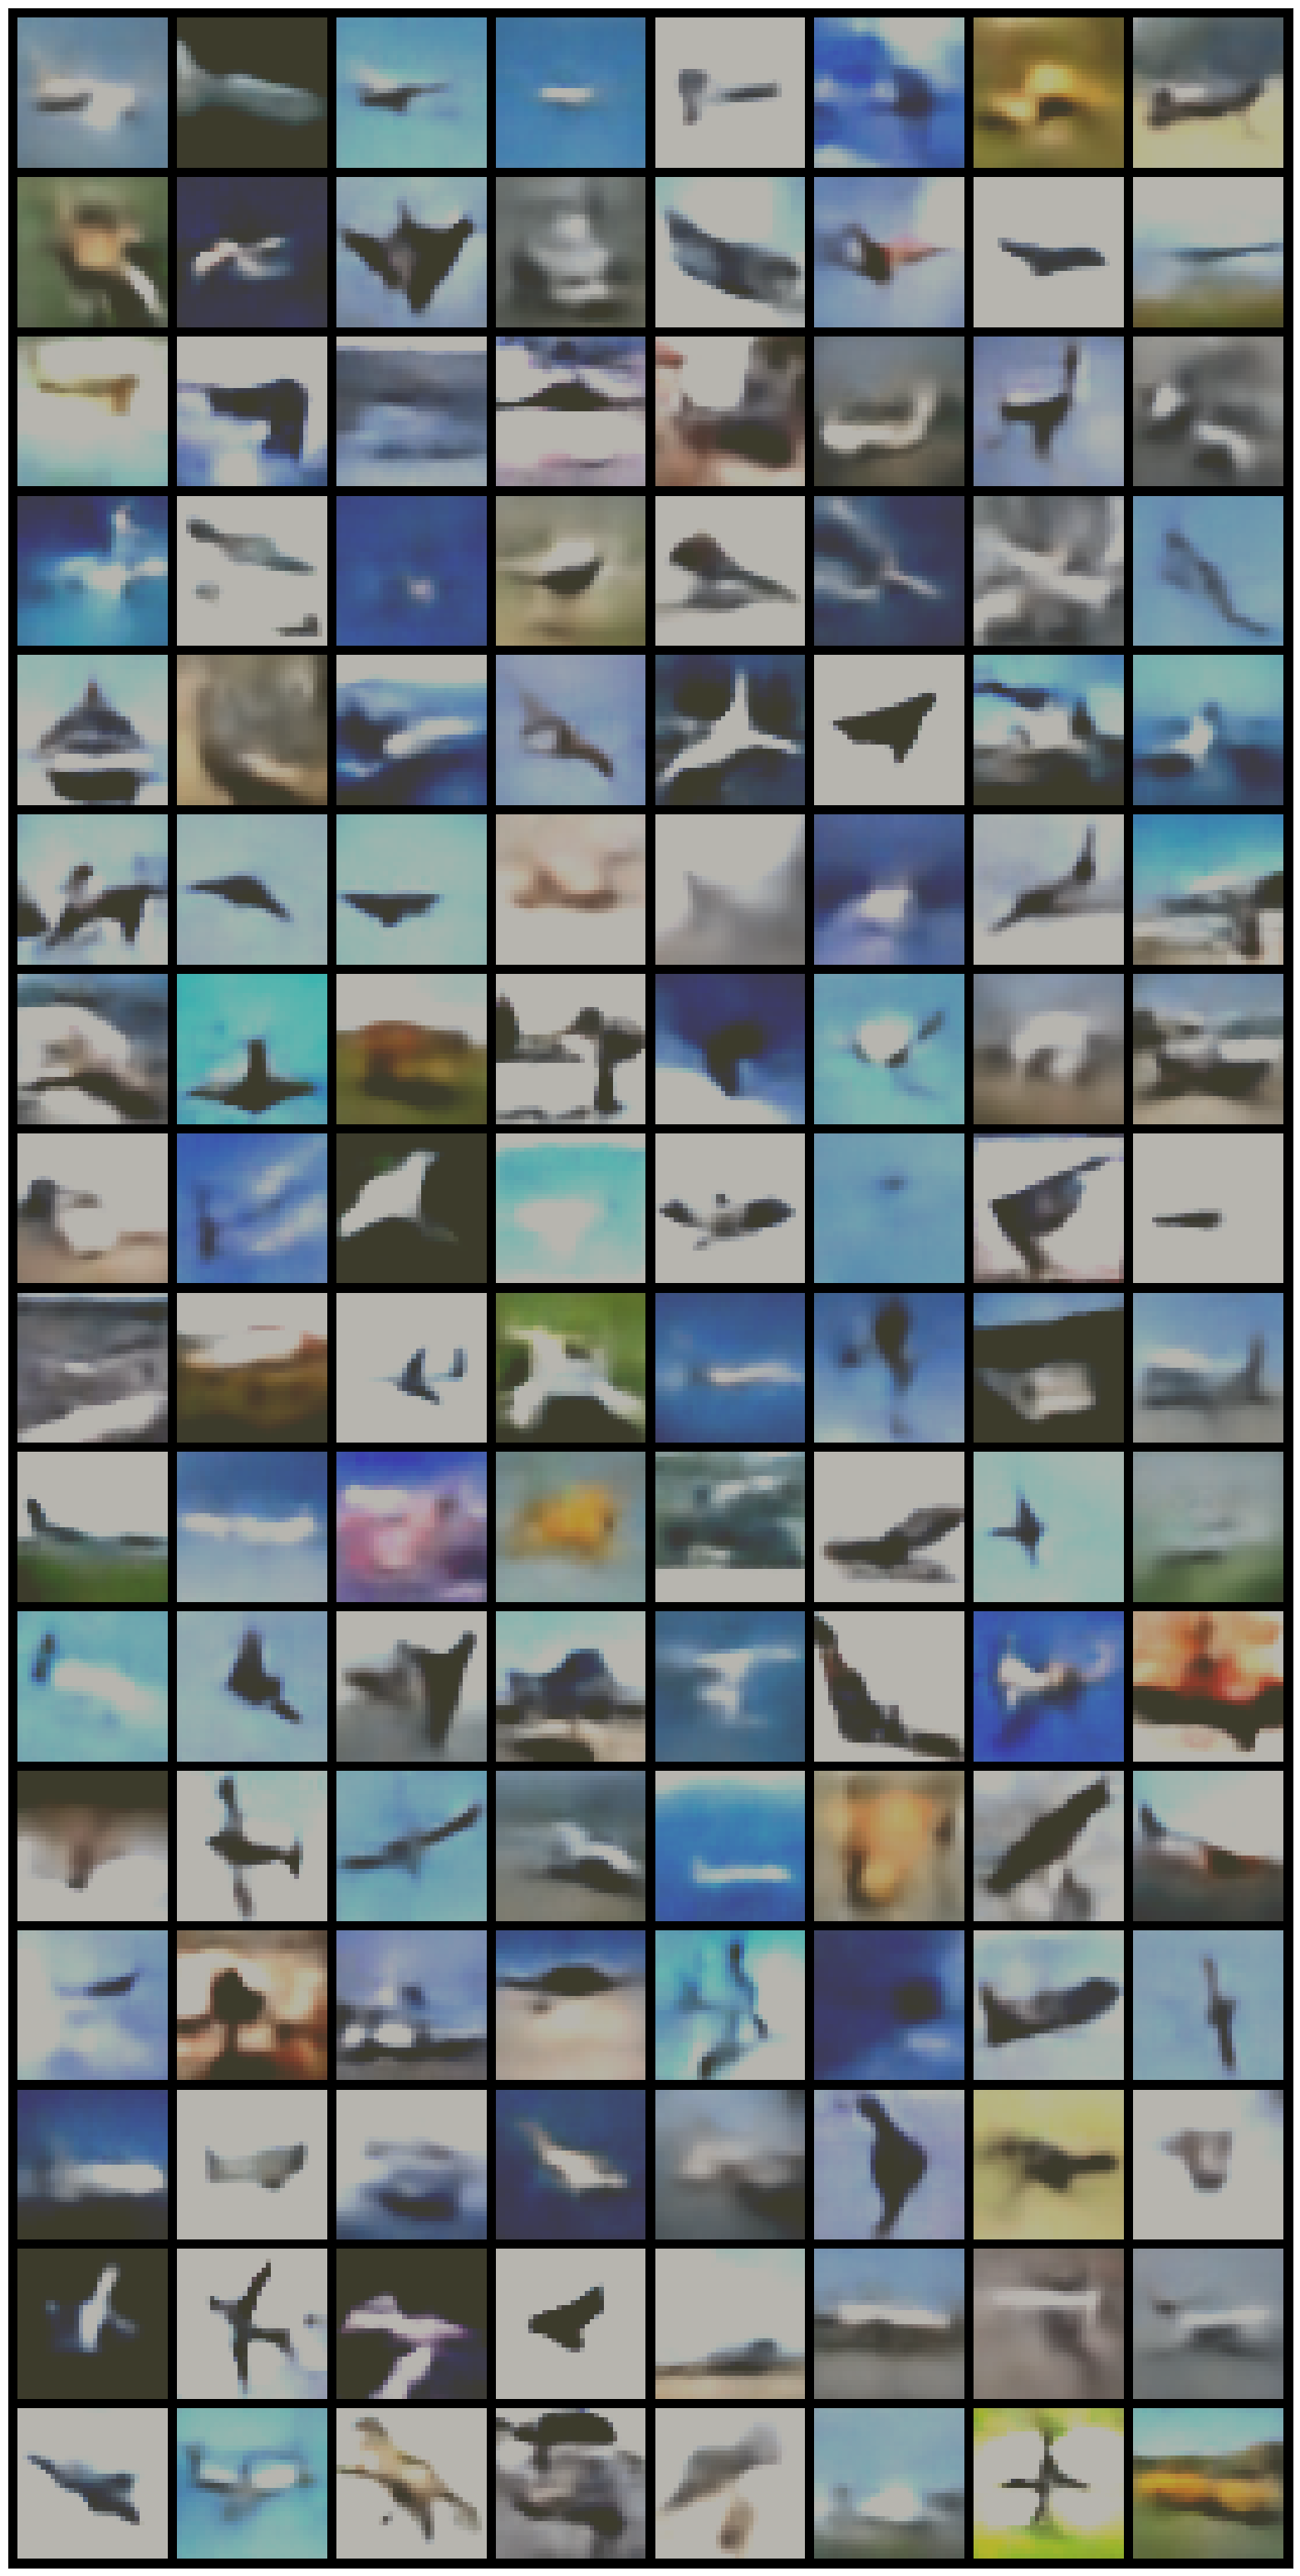

In [10]:
test_input, _ = next(iter(test_dl))
test_input = test_input.to(device)

# mean = [0.47889522, 0.47227842, 0.43047404]
# std = [0.24205776, 0.23828046, 0.25874835]

invnorm = transforms.Compose(
    [
        transforms.Normalize(mean = [0., 0., 0.], std = [1/0.24205776, 1/0.23828046, 1/0.25874835]),
        transforms.Normalize(mean = [-0.47889522, -0.47227842, -0.43047404], std = [1., 1., 1.]),
    ]
)

model.eval()
with torch.no_grad():
    recons, _, _ = model(test_input)

    inv_recons = invnorm(recons)

grid = make_grid(inv_recons)
show(grid)

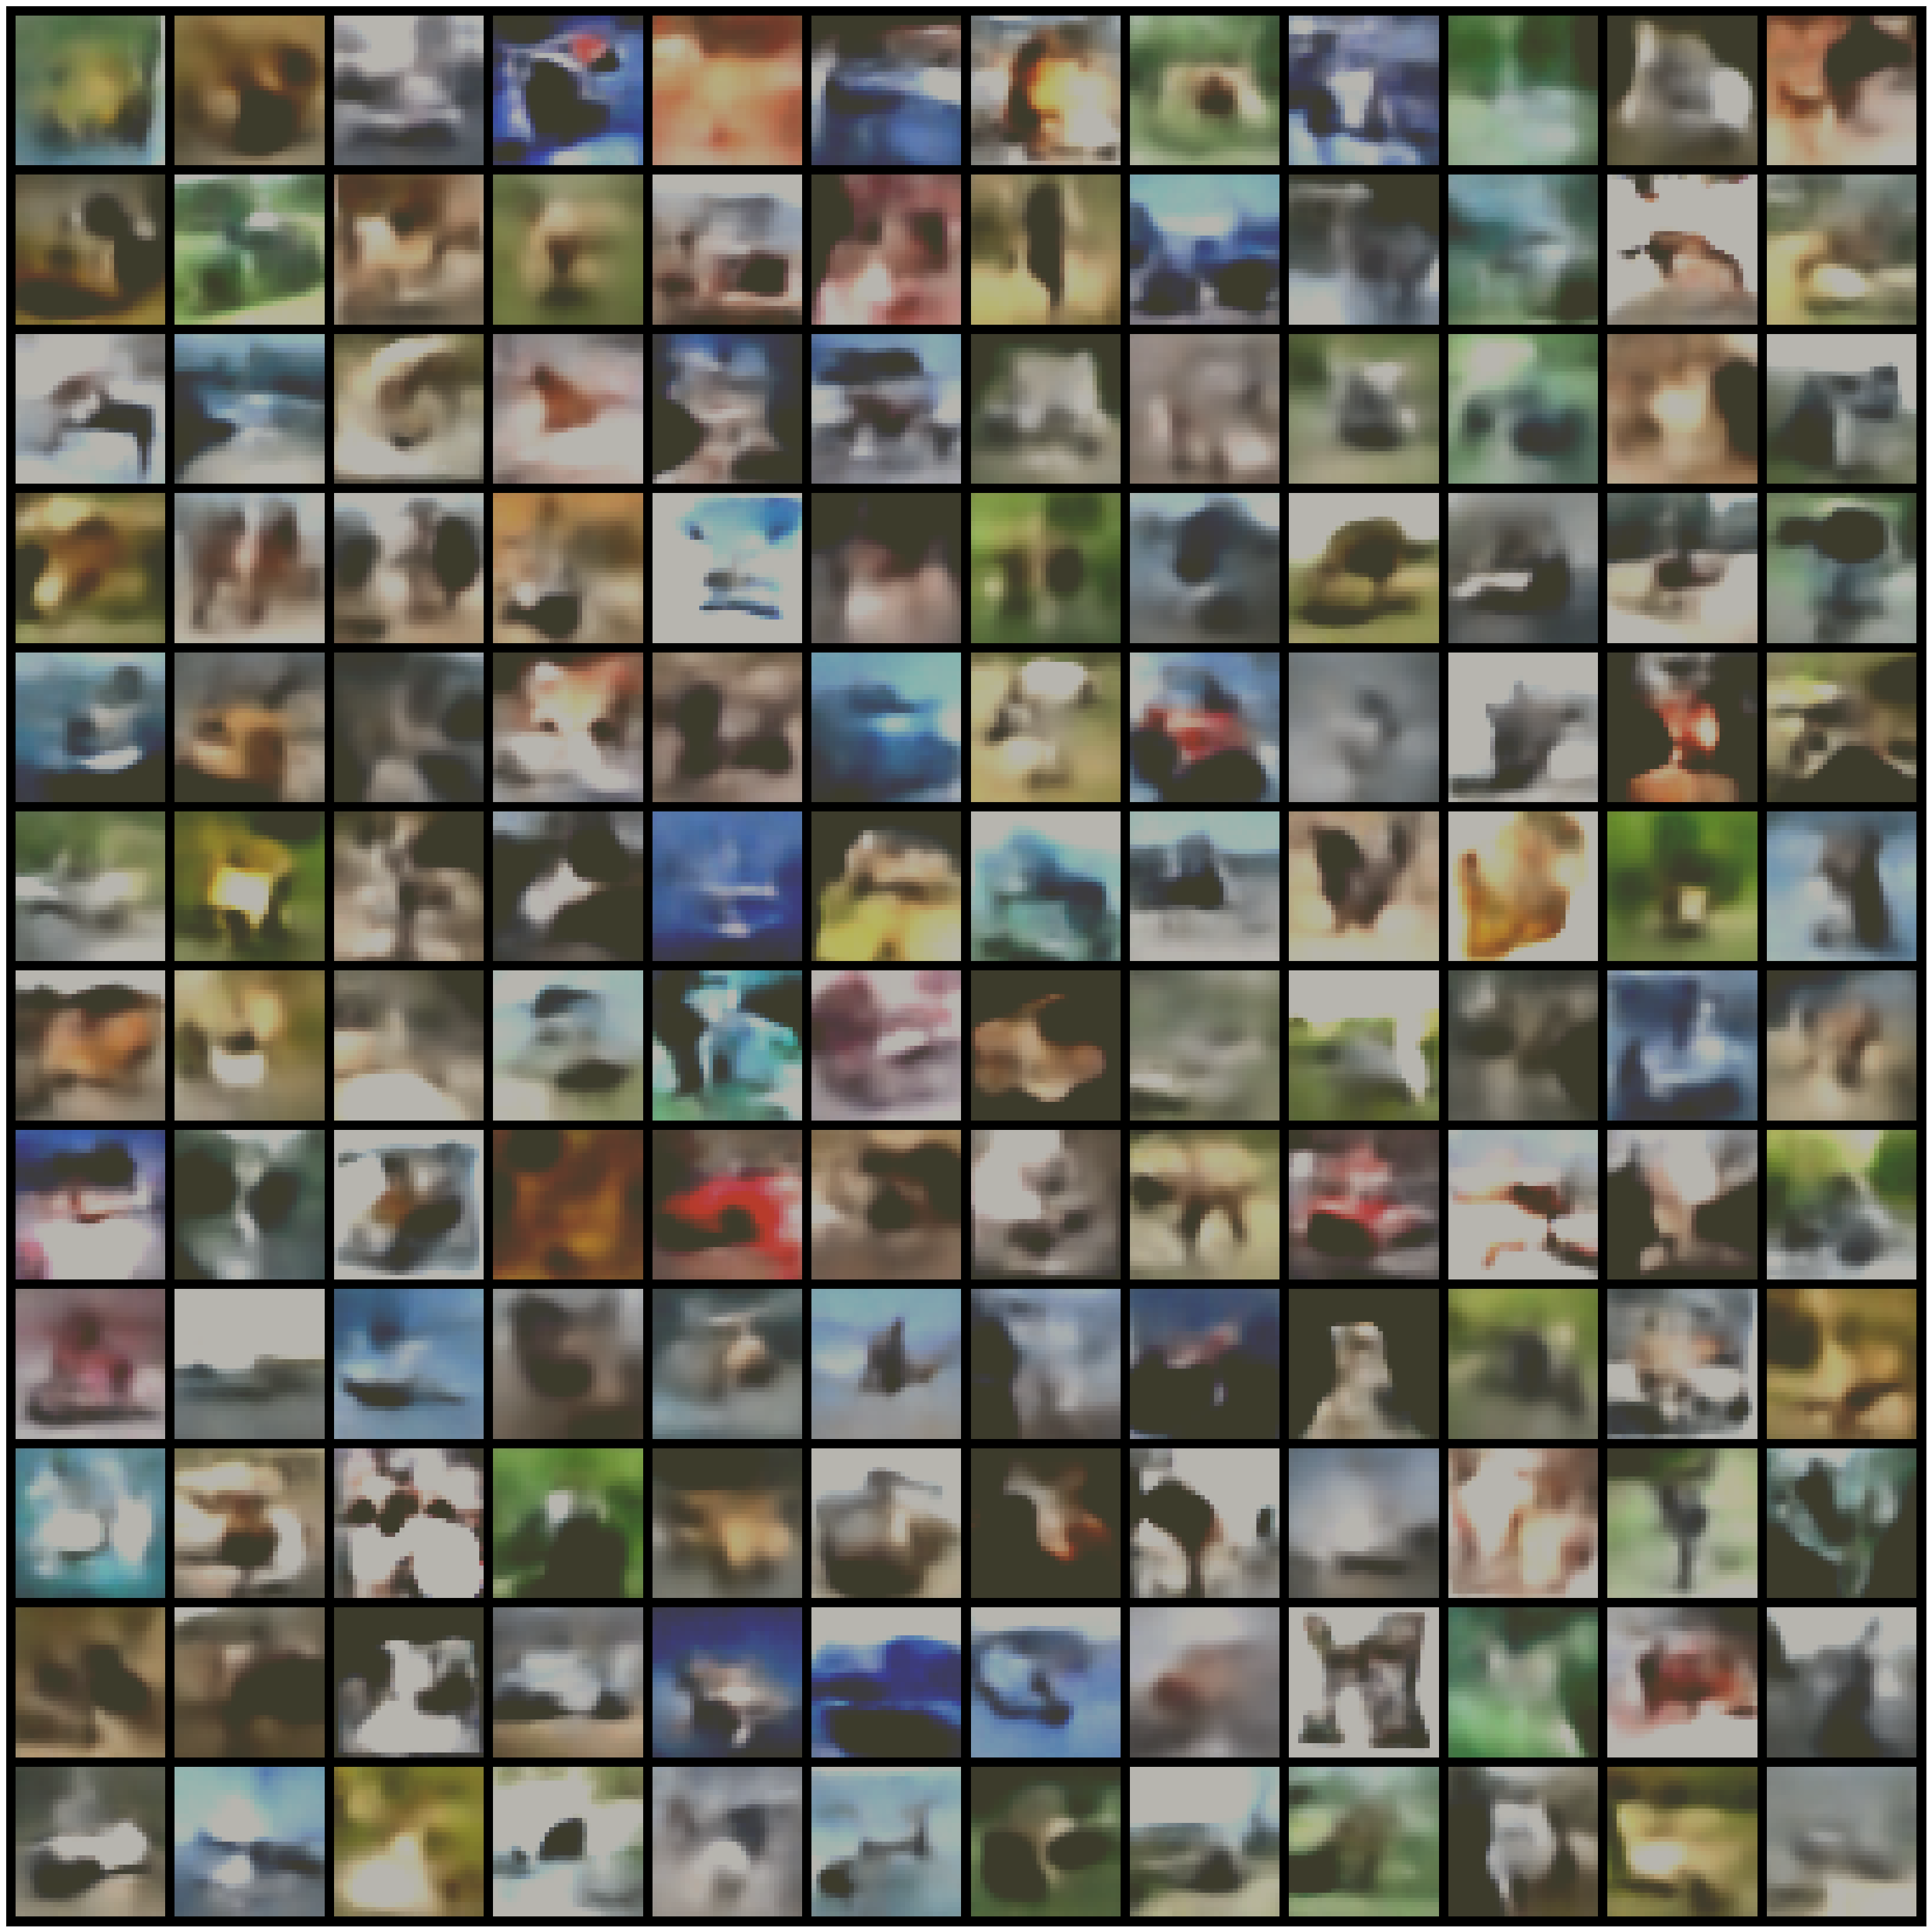

In [11]:
z = torch.randn(144, 256).to(device)

samples = model.decoder(z)

grid = make_grid(invnorm(samples), nrow=12)
show(grid)